# Анализ рынка заведений общественного питания Москвы

В проекте представлена информация о заведениях общественного питания города Москвы. Информация полученна из сервисов Яндекс Карты и Яндекс Бизнес, актуальность данных - лето 2022.<br>
<br>
<b>Задачи проекта:</b> <br>
- проанализировать категории заведений общественного питания и их расположение, цены и рейтинги <br>
- предоставить рекомендации для открытия нового заведения категории 'кофейня' 

<b>Содержание проекта:</b><br>
1. Предобработка
2. Анализ данных
3. Рекомендации по открытию нового заведения
4. Общий вывод

### Предобработка

In [1]:
# импорт необходимых библиотек
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from folium import Map, Choropleth
from folium import Marker, Map
from folium.plugins import MarkerCluster
import json
state_geo = 'admin_level_geomap.geojson'
moscow_lat, moscow_lng = 55.751244, 37.618423

<b>Описание датасета:</b> <br>
- название заведения<br>
- категория заведения<br>
- адрес заведения<br>
- административный район<br>
- иформация о днях и часах работы<br>
- широта географической точки<br>
- долгота географической точки<br>
- рейтинг заведения <br>
- категория цен в заведении <br>
- диапазон средней стоимости заказа <br>
- средний чек<br>
- цена одной чашки капучино<br>
- сетевое / несетовое заведение (bool)<br>
- количество посадочных мест<br>

In [2]:
# получение датасета
data = pd.read_csv('data.csv')
display(data.head(1))
print('Кол-во строк и столбцов:', data.shape)
# доолнительно - анализ на типы данных:
# data.info()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.47886,5.0,NaN,NaN,NaN,NaN,0,NaN


Кол-во строк и столбцов: (8406, 14)


In [3]:
# проверка на наличие дубликатов в датасете
print('Кол-во дубликатов в исходных данных:',data.duplicated().sum())
data['name_category_adres_lower'] = data['name'].str.lower() + ' , ' + data['category'].str.lower() + ' , ' + data['address'].str.lower()
print('Кол-во дубликатов по полям имя+категория+адрес в нижнем регистре:',data.duplicated(subset = ['name_category_adres_lower']).sum())
print('Кол-во дубликатов по полям имя+категория+адрес в нижнем регистре + геоданные:',data.duplicated(subset = ['name_category_adres_lower','lat','lng']).sum())

Кол-во дубликатов в исходных данных: 0
Кол-во дубликатов по полям имя+категория+адрес в нижнем регистре: 2
Кол-во дубликатов по полям имя+категория+адрес в нижнем регистре + геоданные: 1


In [4]:
# удаление заведения по совпедению по полям имя+категория+адрес в нижнем регистре + геоданные
data = data.drop_duplicates(subset = ['name_category_adres_lower','lat','lng'])

Была удалена 1 строка - заведение с явным дубликатом в датасете

In [5]:
# проверка пропусков в данных
# print('Кол-во пропусков:', data.isna().sum())
# нахождение доли пропусков в столбцах, где есть пропуски, от всей базы
# print(round(data[['hours','price','avg_bill','middle_avg_bill','middle_coffee_cup','seats']].isna().mean(),3))

Были проанализированы пропуски в различных столбцах => сохранены, так как в датасете нет информации в других столбцах, на основании которой можно было бы заполнить пропуски

In [6]:
# добавление столбца street с названиями улиц из столбца с адресом
def street (row):
    row = row.split(', ')[1]
    return row
data['street'] = data['address'].apply(street)

In [7]:
# добавление столбца is_24/7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7)
def open_24_7 (row):
    if row == 'ежедневно, круглосуточно':
        return True
    return False
data['is_24_7'] = data['hours'].apply(open_24_7)

In [8]:
# дополнительно добавим новый столбец с сокращением названия Административного округа до "АО" (для удобства построения графиков)
data['district_2'] = data['district'].str.replace('административный округ', 'АО')

Были добавлены необходимые для анализа столбцы через применение функции и метода 'replace'

### Анализ данных

<b>/ Анализ заведений по категориям </b>

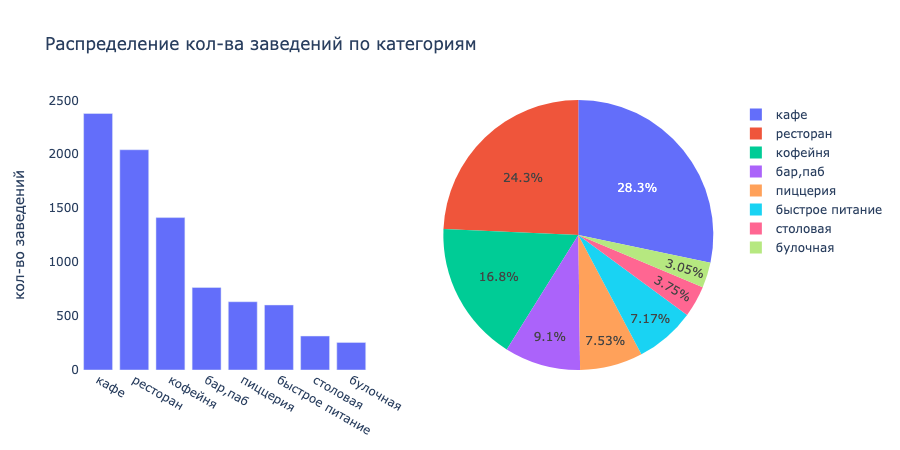

In [9]:
# распределение заведений по категориям
category_count = data.groupby('category').agg({'name' : 'count'})
#category_count['category_share_%'] = round(category_count['name'] / category_count['name'].sum(),3)
#display(category_count.sort_values(by='category_share_%', ascending = False))
category_count_chart = category_count.sort_values(by='name', ascending = False).reset_index()
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])
fig.add_trace(go.Bar(x=category_count_chart['category'], y = category_count_chart['name'],showlegend=False), 1, 1)
fig.add_trace(go.Pie(values=category_count_chart['name'],labels=category_count_chart['category'],showlegend=True), 1, 2)
fig.update_layout(
    title_text='Распределение кол-ва заведений по категориям',
    yaxis_title="кол-во заведений", 
    plot_bgcolor = "rgba(0,0,0,0)")
fig.show(renderer='png', width = 900, height = 450)

<b> Выводы: </b> <br>
- больше всего заведений в категории 'кафе', далее большая доля у ресторанов и кофеен <br>
- меньше всего заведений в категории 'булочная' и 'столовая'

<b>/ Анализ соотношения сетевых и несетевых заведений </b>

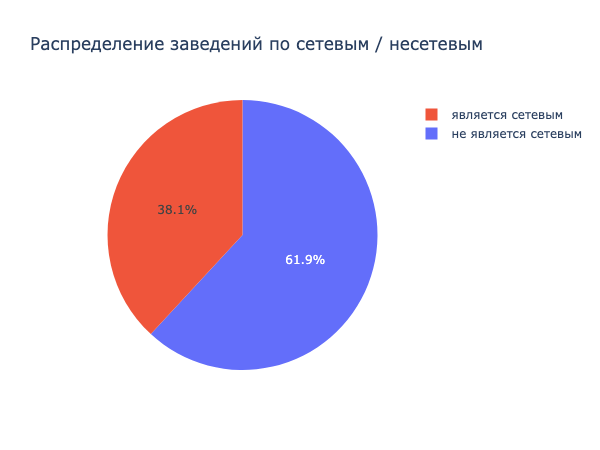

In [10]:
# соотношение сетевых и несетевых заведений (если в 'chain' 1 — заведение является сетевым)
chain_count = data.groupby('chain').agg({'name':'count'})
#print(chain_count)
fig = go.Figure(data=[go.Pie(labels=['не является сетевым','является сетевым'], values=chain_count['name'])])
fig.update_layout(
    title='Распределение заведений по сетевым / несетевым', 
    legend_traceorder="reversed", 
    #width=600, height=450
    )
fig.show(renderer='png', width = 600, height = 450) 

<b> Выводы: </b> <br>
- большинство (62%) заведений не являются сетевыми

<b>/ Анализ категорий сетевых заведений </b>

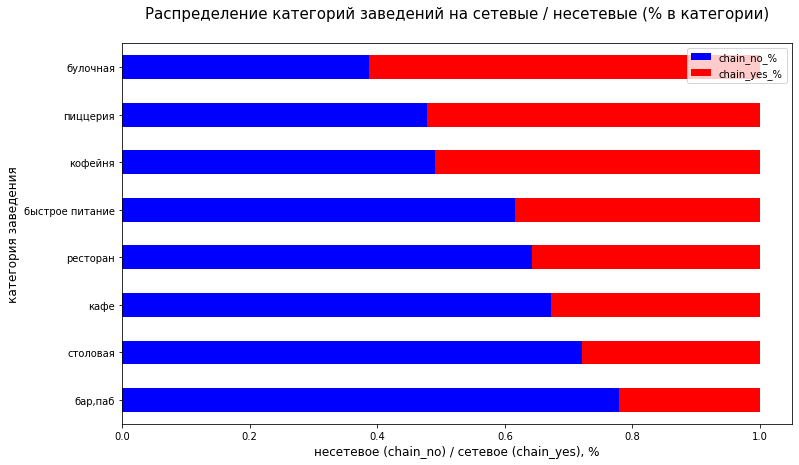

In [11]:
# распределение сетевых / несетевых заведений по категориям
category_chain = data.pivot_table(index = 'category', columns = 'chain', values = 'name', aggfunc = 'count')
category_chain.columns = ['chain_no', 'chain_yes']
category_chain['chain_no_%'] = category_chain['chain_no'] / (category_chain['chain_no'] + category_chain['chain_yes'])
category_chain['chain_yes_%'] = category_chain['chain_yes'] / (category_chain['chain_no'] + category_chain['chain_yes'])
#display(category_chain.sort_values(by='chain_yes_%',ascending = False))
category_chain_share = category_chain.drop(columns = ['chain_no','chain_yes'])
category_chain_share.sort_values(by = 'chain_yes_%').plot(kind='barh',color=['b','r'],stacked = True,figsize=(12,7))
plt.title('Распределение категорий заведений на сетевые / несетевые (% в категории)', size = 15, y=1.05)
plt.xlabel('несетевое (chain_no) / сетевое (chain_yes), %', size = 12)
plt.ylabel('категория заведения', size = 12)
plt.show()

<b> Выводы: </b> <br>
- чаще всего сетевыми являются 'булочные' <br>
- больше половины категории заведений являются сетевыми у 'пиццерий' и у 'кофеен' <br>
- реже всего сетевыми являются 'бары,пабы' <br>

<b>/ Анализ топ-15 популярных сетей в Москве </b>

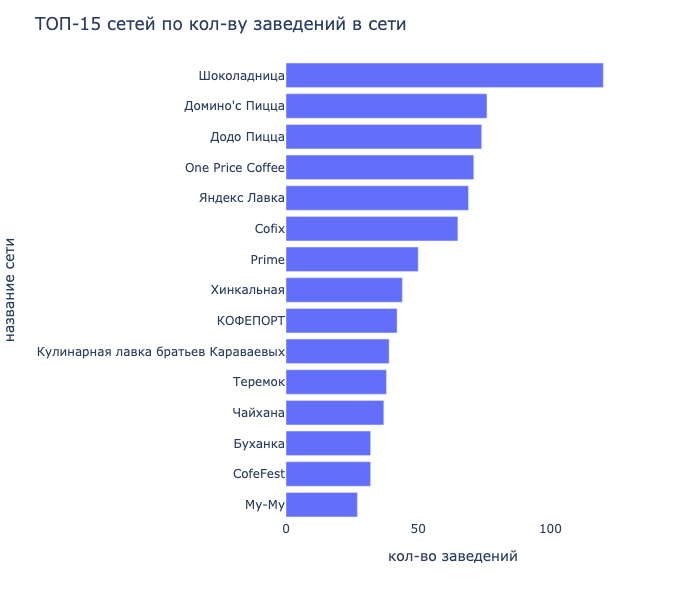

In [12]:
# анализ ТОП-15 сетевых заведений (сетей)
chain_yes_data = data[data['chain']==1]
top_chains = chain_yes_data.groupby('name', as_index = False).agg({'chain':'count'}).sort_values(by='chain', ascending=False).head(15)
#display(top_chains)
#print('Кол-во заведений в ТОП-15 сетей (суммарно):',top_chains['name].sum())
fig = px.bar(top_chains.sort_values(by='chain'), x='chain', y='name' )
fig.update_layout(
    title="ТОП-15 сетей по кол-ву заведений в сети",
    xaxis_title="кол-во заведений",
    yaxis_title="название сети",
    plot_bgcolor = "rgba(0,0,0,0)",
    #width=700, height=600
    )
fig.show(renderer='png', width = 700, height = 600)

<b> Выводы: </b> <br>
-самые популярные сети по кол-ву заведений: 'Шоколадница', 'Домино'с Пицца' и  'Додо Пицца' <br>
<br>
Заведения, объединенные по названию 'Хинкальная' и 'Чайхана', возможно, не являются заведениями одной сети, однако в датасете нет данных для проверки (ИНН или другая информация) => 'Хинкальная' и 'Чайхана' сохранены в анализе как сетевые заведения

<b>/ Анализ заведений по административным округам </b>

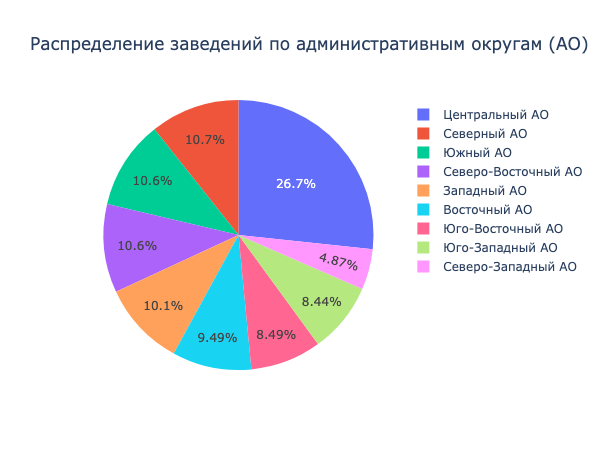

In [13]:
# анализ кол-ва заведений по административным округам Москвы
district_count = data.groupby('district_2', as_index = False).agg({'name':'count'})
#display(district_count.sort_values(by='name',ascending = False))
fig = go.Figure(data=[go.Pie(labels= district_count['district_2'], values=district_count['name'])])
fig.update_layout(
    title='Распределение заведений по административным округам (АО)', 
    #width=600, height=450
    )
fig.show(renderer='png', width = 600, height = 450) 

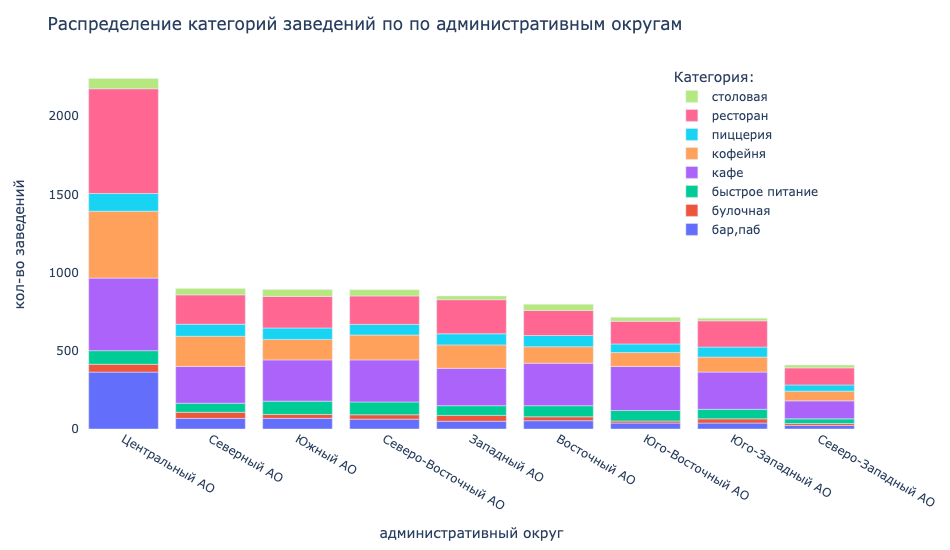

In [14]:
# анализ данных по округам и по категориям заведений
district_category = data.groupby(['district_2','category'],as_index = False).agg({'name':'count'})
fig = px.bar(district_category, x='district_2', y='name',  color='category')
fig.update_xaxes(tickangle=30)
fig.update_layout(
    xaxis={'categoryorder': 'total descending'},
    title="Распределение категорий заведений по по административным округам",
    xaxis_title="административный округ",
    yaxis_title="кол-во заведений",
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория:',
    legend_traceorder="reversed",
    legend = dict(yanchor="top",  y=0.99, xanchor="right", x=0.95 )
    #width=950, height=550
    )
fig.show(renderer='png', width = 950, height = 550)

<b> Выводы: </b> <br>
- больше всего заведений находится в Центральном АО, меньше всего в Северо-Западном АО <br>
- в Центральном АО (больше всего заведений) в основном категории: 'ресторан', 'кофейня', 'кафе', 'бар,паб' <br>
- в остальных округах основную долю занимают 'кафе' и 'рестораны'  <br>

<b>/ Анализ рейтингов заведений </b>

Средний рейтинг всех заведений общественного питания: 4.23


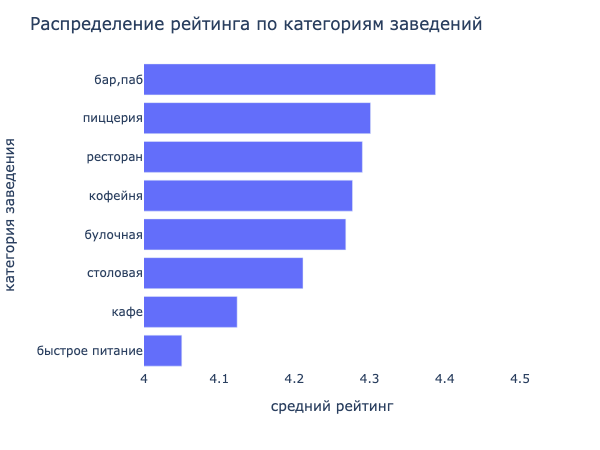

In [15]:
# средний рейтинг всех заведений общественного питания
print('Средний рейтинг всех заведений общественного питания:',round(data['rating'].mean(),3))
# анализ среднего рейтинга по категоиям заведений
category_rating = data.groupby('category', as_index= False).agg({'rating':'mean'})
#display(category_rating.sort_values(by='rating',ascending=False))
fig = px.bar(category_rating.sort_values(by='rating'), x='rating', y='category')
fig.update_layout(
    title="Распределение рейтинга по категориям заведений",
    xaxis_title="средний рейтинг",
    yaxis_title="категория заведения",
    plot_bgcolor = "rgba(0,0,0,0)"
    #width=600, height=450
    )
fig.update_xaxes(range=[4, 4.5])
fig.show(renderer='png', width = 600, height = 450)

<b> Выводы: </b> <br>
- средний рейтинг всех заведений общественного питания: 4.23 <br>
- средний рейтинг заведений в зависимости от категории варьируется от 4.0 до 4.4: наилучший рейтинг у 'бар, паб', наименьший рейтинг у 'кафе' и 'быстрое питание'

<b>/ Картограмма рейтингов по районам </b>

In [16]:
# анализ среднего рейтинга по округам
district_rating = data.groupby('district',as_index=False).agg({'rating':'mean'})
# фоновая картограмма (хороплет) со средним рейтингом заведений по округам
m1 = Map(location=[moscow_lat, moscow_lng], zoom_start=10)
Choropleth(
    geo_data=state_geo,
    data=district_rating,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='RdPu',
    fill_opacity=0.8,
    legend_name='Средний рейтинг заведений по округам',
    ).add_to(m1)
#m1

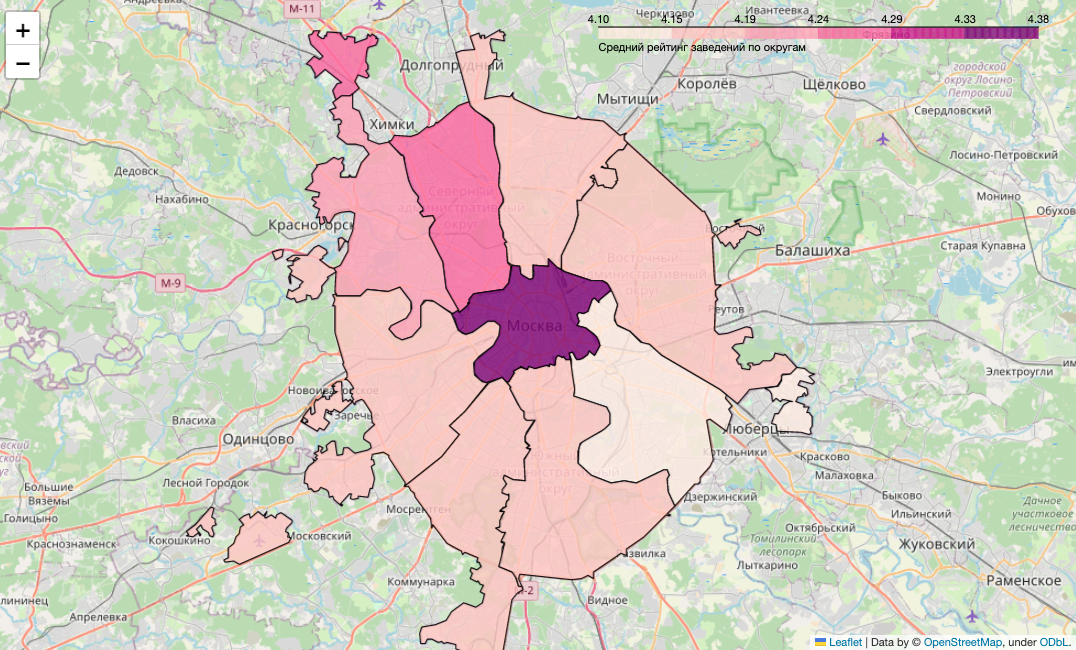

<b> Выводы: </b> <br>
Средний рейтинг заведений в зависимости от административного округа варьируется от 4.1 до 4.4:<br>
- наилучший рейтинг в Центральном АО (4.4)<br>
- наименьший рейтинг в Северо-Восточном и Юго-Восточном АО (4.1)

<b>/ Анализ заведений по улицам: ТОП-15 </b>

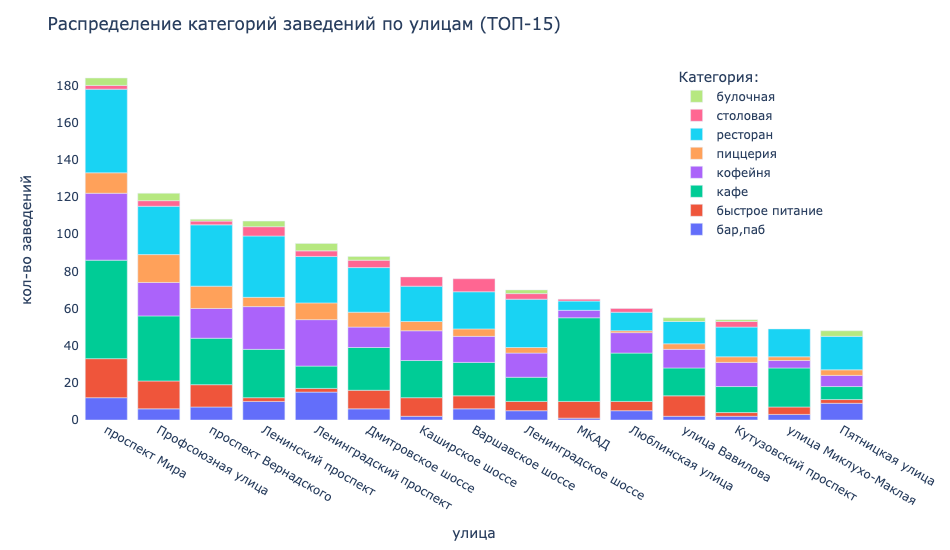

In [17]:
# анализ данных по улицам и по категориям заведений
top_streets = data.groupby('street').agg({'name':'count'}).sort_values(by='name', ascending=False).head(15)
top_streets_data = data.query('street in @ top_streets.index')
street_category = top_streets_data.groupby(['street','category'],as_index = False).agg({'name':'count'})
fig = px.bar(street_category, x='street', y='name',  color='category')
fig.update_xaxes(tickangle=30)
fig.update_layout(
    xaxis={'categoryorder': 'total descending'},
    title="Распределение категорий заведений по улицам (ТОП-15)",
    xaxis_title="улица",
    yaxis_title="кол-во заведений",
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория:',
    legend_traceorder="reversed",
    legend = dict(yanchor="top",  y=0.99, xanchor="right", x=0.95 )
    #width=950,height=550
    )
fig.show(renderer='png', width = 950, height = 550)

<b> Выводы: </b> <br>
На ТОП-15 улицах чаще встречаются заведения категорий 'ресторан', 'кофейня', 'кафе' <br>
- имеются улицы, где отстутсвуют категориии:  'булочная' (Каширское, Варшавское шоссе, Люблинская улица и улица Миклухо-Маклая),  'пиццерия' (МКАД) <br>
- в ТОП-15 улиц по кол-ву заведений попали самые длинные по километражу улицы города (кроме улицы Миклухо-Маклая и Пятницкой улицы)

<b>/ Анализ среднего чека по категориям</b>

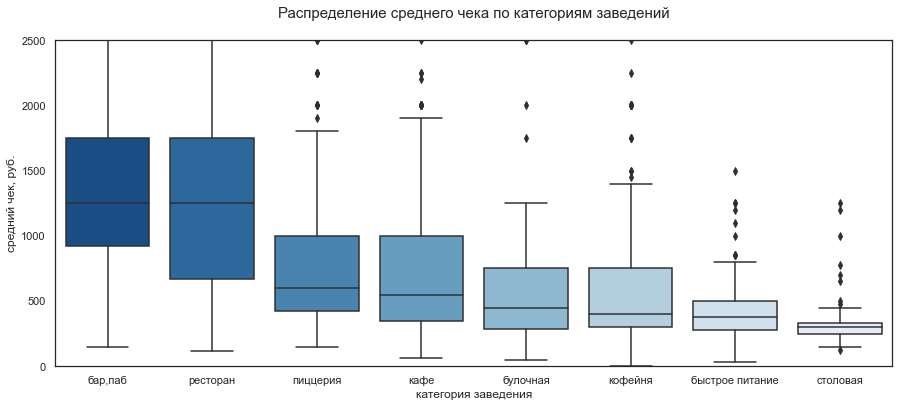

In [18]:
# анализ среднего чека по категориям заведений
category_middle_avg_bill = data.groupby('category').agg({'middle_avg_bill':'median'})
#display(category_middle_avg_bill.sort_values(by='middle_avg_bill', ascending=False))
plt.figure(figsize=(15, 6))
sns.set(style="white")
order = category_middle_avg_bill.sort_values(by='middle_avg_bill',ascending=False).index
ax = sns.boxplot(x='category', y='middle_avg_bill', data=data, order = order, palette="Blues_r")
plt.title('Распределение среднего чека по категориям заведений', size = 15, y= 1.05)
plt.ylim(0,2500)
plt.xlabel('категория заведения', size = 12)
plt.ylabel('средний чек, руб.', size = 12)
plt.show()

<b> Выводы: </b> <br>
- наиболее выгодные заведения по среднему чеку: 'бар,паб' и 'ресторан' (средний чек 1250 рублей)  <br>
- наименее выгодные заведения по среднему чеку: 'столовая' (375 рублей) и 'быстрое питание' (300 рублей)

<div style="border:solid lightblue 2px; padding: 5px">
<b>Вывод по Анализу заведений общественного питания Москвы:</b> <br>
</u>  <br>
<u>Категории заведений:   </u>  <br>
В датасете представлены 8 категорий заведений: кафе, ресторан, кофейня, пиццерия, бар,паб, быстрое питание, булочная, столовая<br>
-больше всего заведений в категории 'кафе' (28,3%)<br>
-большая доля у ресторанов (24,3%) и кофеен (16,8%)<br>
-меньше всего заведений в категории 'булочная' (3%) и 'столовая' (3,7%)<br>
<br> 
<u>Сетевые заведения в Москве:   </u>  <br>    
-сетевых заведений 38% от всех заведений общепита (не являются сетевыми 62% заведений)<br>   
-чаще всего сетевыми являются 'булочные' (61% сетевых)<br>   
-у 'пиццерий' и у 'кофеен' ~50% заведений являются сетевыми<br>   
-реже всего сетевыми являются 'бары,пабы' (22% сетевых)<br>   
<br> 
<u>Популярные сети в Москве:   </u>  <br> 
-самые популярные сети по кол-ву заведений: 'Шоколадница', 'Домино'с Пицца' и 'Додо Пицца'<br>   
<br>   
<u>Распределение заведений по округам Москвы:   </u>  <br> 
-больше всего заведений находится в Центральном АО (27%), меньше всего заведений находится в Северо-Западном АО (5%)<br> 
-в Центральном АО  в основном категории: 'ресторан', 'кофейня', 'кафе', 'бар,паб' <br>
-в остальных округах основную долю занимают 'кафе' и 'рестораны'  <br>
<br>   
<u>Рейтинги заведений Москвы:   </u>  <br> 
Средний рейтинг всех заведений общественного питания: 4.23<br>
Средний рейтинг заведений в зависимости от категории варьируется от 4.0 до 4.4:<br> 
-наилучший рейтинг у категории 'бар, паб' (4.4)<br> 
-наименьший ретинг у категорий 'кафе' (4.1) и 'быстрое питание' (4.0)<br> 
Средний рейтинг заведений в зависимости от административного округа варьируется от 4.1 до 4.4:<br>
-наилучший рейтинг в Центральном АО (4.4)<br>
-наименьший рейтинг в Северо-Восточном и Юго-Восточном АО (4.1)<br>
<br> 
<u>Популярные улицы по кол-ву заведений:   </u>  <br> 
-самые популярные улицы по кол-ву заведений: 'проспект Мира', 'Профсоюзная улица', 'проспект Вернадского' и 'Ленинский проспект'<br>
-на ТОП-15 улицах чаще встречаются заведения категорий 'ресторан', 'кофейня', 'кафе'<br>
<br>
<u>Средний чек заведений:   </u>  <br> 
-средний чек всех заведений общественного питания: 750 рублей <br>
-наиболее выгодные заведения по среднему чеку: 'бар,паб' и 'ресторан' (средний чек 1250 рублей)<br>
-наименее выгодные заведения по среднему чеку: 'столовая' (375 рублей) и 'быстрое питание' (300 рублей)  <br>

### Рекомендации по открытию нового заведения

Далее представлен анализ заведений категории 'кофейня' с целью предоставления рекомендаций для открытия нового заведения

In [19]:
# создание переменной с отсортированным датасетом
coffee_house_data = data[data['category'] == 'кофейня']

<b>/ Анализ кофеен по округам и улицам </b>

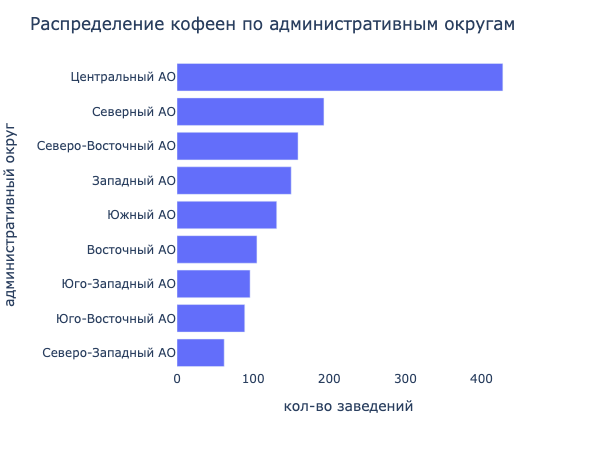

In [20]:
# анализ категории 'кофейни' по округам
coffee_house_district = coffee_house_data.groupby('district_2', as_index= False).agg({'name':"count"})
#display(coffee_house_district.sort_values(by='name',ascending = False))
fig = px.bar(coffee_house_district.sort_values(by='name'), x='name', y='district_2')
fig.update_layout(
    title="Распределение кофеен по административным округам",
    xaxis_title="кол-во заведений",
    yaxis_title="административный округ",
    plot_bgcolor = "rgba(0,0,0,0)"
    #width=600,height=450
    )
fig.show(renderer='png', width = 600, height = 450)

<b> Выводы: </b> <br>
-заведений категории 'кофейня' больше всего в Центральном АО и меньше всего в Северо-Западном АО <br>

In [21]:
# расположение кофеен на одной улице (плотность)
coffee_house_district_street = coffee_house_data.groupby(['district_2', 'street']).agg({'name':'count'}).reset_index()
coffee_house_district_street_mean = coffee_house_district_street.groupby('district_2').agg({'street':'count','name':'mean'})
coffee_house_district_street_mean.columns = ['street_count','coffee_house_mean']
coffee_house_district_street_mean['coffee_house_mean'] = round(coffee_house_district_street_mean['coffee_house_mean'],3)
display(coffee_house_district_street_mean.sort_values(by='coffee_house_mean', ascending=False))

,street_count,coffee_house_mean
district_2,,
Западный АО,55,2.727
Юго-Западный АО,38,2.526
Северный АО,79,2.443
Южный АО,54,2.426
Северо-Восточный АО,68,2.338
Центральный АО,210,2.038
Юго-Восточный АО,44,2.023
Северо-Западный АО,36,1.722
Восточный АО,63,1.667


<b> Выводы: </b> <br>
- по кол-ву заведений категории 'кофейня' на одной улице самая высокая плотность в Западном АО<br>
- наименьшая плотность на улицу в Северо-Западном и Восточном АО <br>
<br>
=> стоит отдать предпочтение АО с большим кол-вом заведений, так как в них публика уже привыка к такому типу заведений: <br>
по кол-ву кофеен + по плотности заведений это: Центральный, Северный, Северо-Восточный, Западный, Южный и Юго-Западный<br>
=> не стоит открываться в районах, где кофейни не популярны: Восточный, Юго-Восточный, Северо-Западный

<b>/ Анализ кофеен по режиму работы </b>

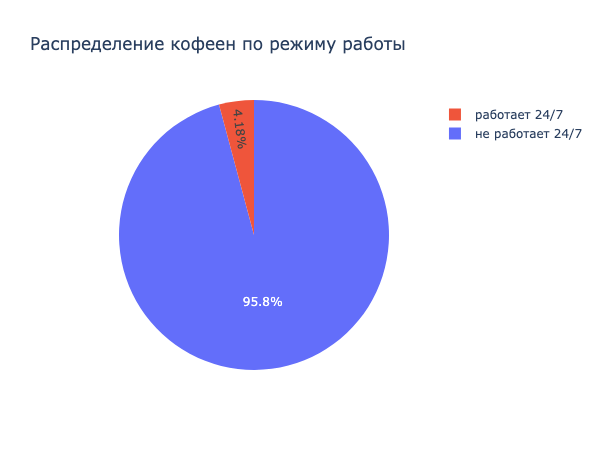

In [22]:
# анализ категории 'кофейни' по режиму работы (круглосуточно)
coffee_house_24_7 = coffee_house_data.groupby('is_24_7').agg({'name':'count'})
fig = go.Figure(data=[go.Pie(labels=['не работает 24/7','работает 24/7'], values=coffee_house_24_7['name'])])
fig.update_layout(
    title='Распределение кофеен по режиму работы', 
    legend_traceorder='reversed'
    #width=600,  height=450
    )
fig.show(renderer='png', width = 600, height = 450) 

<b> Выводы: </b> <br>
- заведения категории 'кофейня' чаще не работают 24/7 (96%)<br>
- лишь 4% заведений категории 'кофейня' открыты круглосуточно   <br>
=> отсутствует необходимость открывать круглосуточное заведение в категории 'кофейня', так как конкуренты не работают 24/7

<b>/ Анализ кофеен по рейтингу заведений </b>

Рейтинг заведений категории кофейня (среднее): 4.277


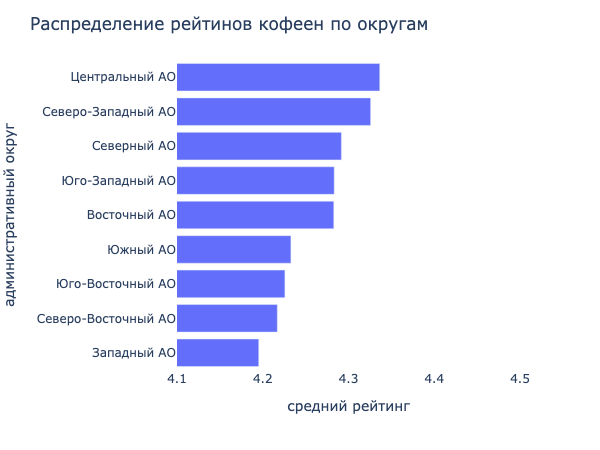

In [23]:
# средний рейтинг в категории 'кофейня'
print('Рейтинг заведений категории кофейня (среднее):', round(coffee_house_data['rating'].mean(),3))
# распределение рейтингов категории 'кофейня' по административным округам
coffee_house_rating = coffee_house_data.groupby('district_2', as_index = False).agg({'rating':'mean'})
#display(coffee_house_rating.sort_values(by = 'rating',ascending=False))
fig = px.bar(coffee_house_rating.sort_values(by='rating'), x='rating', y='district_2')
fig.update_layout(
    title="Распределение рейтинов кофеен по округам",
    xaxis_title="средний рейтинг",
    yaxis_title="административный округ",
    plot_bgcolor = "rgba(0,0,0,0)"
    #width=600,height=450
    )
fig.update_xaxes(range=[4.1, 4.5])
fig.show(renderer='png', width = 600, height = 450)

<b> Выводы: </b> <br>
- средний рейтинг заведений категории 'кофейня' составляет 4,28 (из 5)   <br>
- рейтинги распределены по округам от 4.2 до 4.3   <br>
=> разница в рейтингах 0,1 балл => одинаково хороший рейтинг можно получить в любом округе Москвы <br>

<b>/ Анализ кофеен по средней цене чашки капучино </b>

Размер средней цены одной чашки капучино (медиана): 170.0


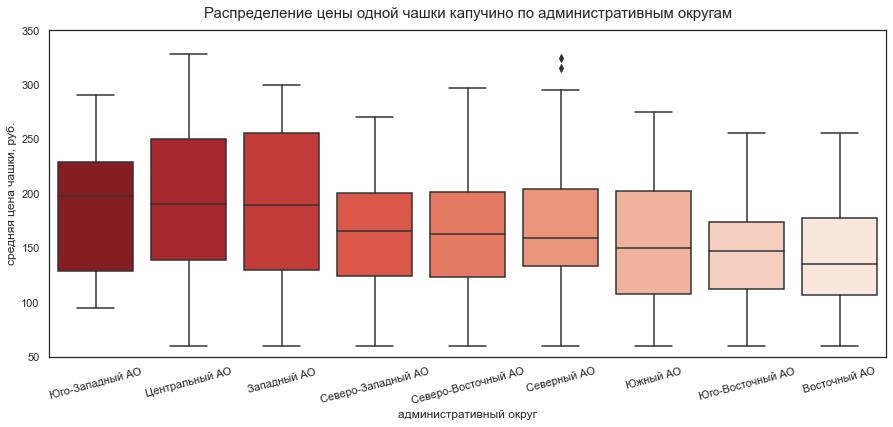

In [24]:
# анализ заведений категории 'кофейни' по средней цене чашки капучино
print('Размер средней цены одной чашки капучино (медиана):', coffee_house_data['middle_coffee_cup'].median())
# стоимость одной чашки капучино по округам
coffee_cup_district = coffee_house_data.groupby('district_2').agg({'middle_coffee_cup':'median'})
#display(coffee_cup_district.sort_values(by='middle_coffee_cup', ascending=False))
# визуализация
plt.figure(figsize=(15, 6))
sns.set(style="white")
order = coffee_cup_district.sort_values(by='middle_coffee_cup', ascending=False).index
ax = sns.boxplot(x='district_2', y='middle_coffee_cup', data=coffee_house_data, order = order, palette="Reds_r")
plt.title('Распределение цены одной чашки капучино по административным округам', size = 15, y=1.02)
plt.xticks(rotation=15)
plt.ylim(50,350)
plt.xlabel('административный округ', size = 12)
plt.ylabel('средняя цена чашки, руб.', size = 12)
plt.show()

<b> Выводы: </b> <br>
- средняя цена одной чашки капучино заведений категории 'кофейня' составляет 170 рублей  <br>
- средняя цена одной чашки капучино выше в Центральном, Западном и Юго-Западном округе (190 - 200 рублей)  <br>
=> разница в цене одной чашки капучино не сильно меняется по округам
=> цену одной чашки капучино в новом заведении необходимо ставить на уровне цены в административном округе

<b>/ Анализ кофеен по среднему чеку </b>

Размер среднего чека в категории кофейня (медиана): 400.0


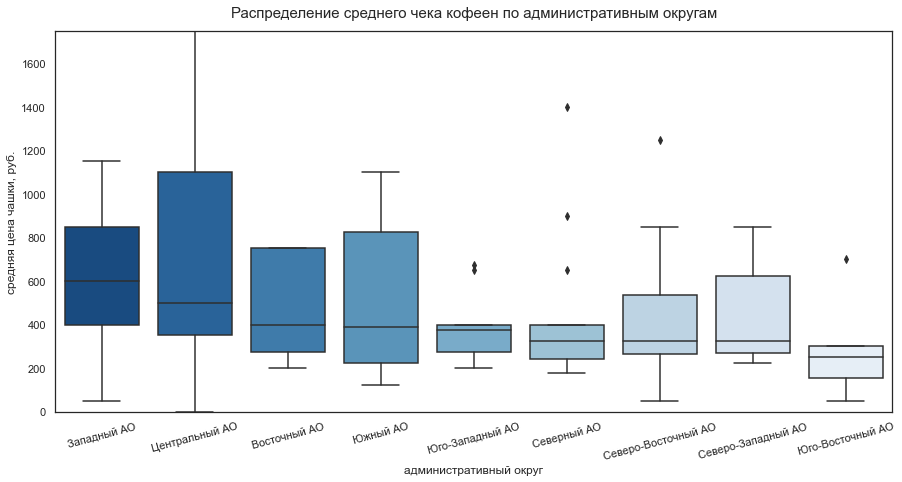

In [25]:
# анализ заведений категории 'кофейни' по среднему чеку
print('Размер среднего чека в категории кофейня (медиана):', coffee_house_data['middle_avg_bill'].median())
# распределение среднего чека кофеен по округам
coffee_avg_bill_district = coffee_house_data.groupby('district_2').agg({'middle_avg_bill':'median'})
#display(coffee_avg_bill_district.sort_values(by='middle_avg_bill', ascending=False))
plt.figure(figsize=(15, 7))
sns.set(style="white")
order = coffee_avg_bill_district.sort_values(by='middle_avg_bill', ascending=False).index
ax = sns.boxplot(x='district_2', y='middle_avg_bill', data=coffee_house_data, order = order, palette='Blues_r')
plt.title('Распределение среднего чека кофеен по административным округам', size = 15, y=1.02)
plt.xticks(rotation=15)
plt.ylim(0,1750)
plt.xlabel('административный округ', size = 12)
plt.ylabel('средняя цена чашки, руб.', size = 12)
plt.show()

<b> Выводы: </b> <br>
- средний чек заведений категории 'кофейня' составляет 400 рублей   <br>
- средний чек выше в и Западном АО (600 рублей) и Центральном АО (500 рублей)<br>
- низкий средний чек в Юго-Восточном АО (250 рублей)  <br>
=> для получения прибыли/возврата инвестиций рекомендуется открывать заведение в округах с высоким чеком: Центральный и Западный

<b>/ Анализ зависимости цены чашки капучино/среднего чека и рейтинга </b>

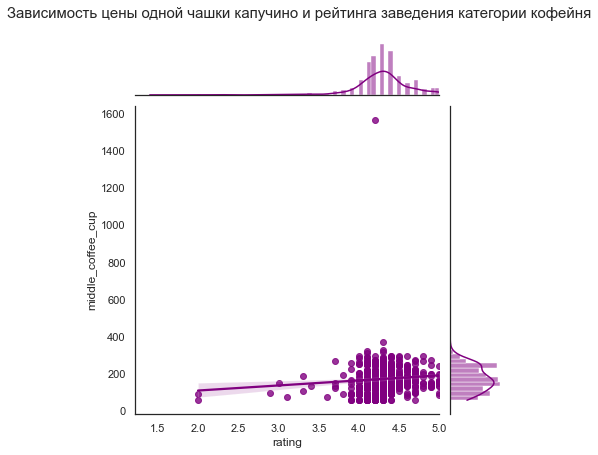

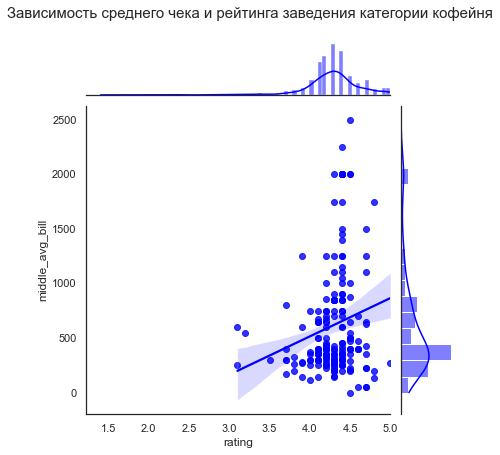

In [26]:
# зависимость цены одной чашки капучино и рейтинга
sns.jointplot(x='rating', y='middle_coffee_cup', data=coffee_house_data, kind='reg', color='purple')
plt.suptitle('Зависимость цены одной чашки капучино и рейтинга заведения категории кофейня', size = 15, y=1.05)
plt.show()
# зависимость среднего чека и рейтинга
sns.jointplot(x='rating', y='middle_avg_bill', data=coffee_house_data, kind='reg', color='blue')
plt.suptitle('Зависимость среднего чека и рейтинга заведения категории кофейня', size = 15, y=1.05)
plt.show()

<b> Выводы: </b> <br>
- не выявлено явной зависимости цены одной чашки капучино в заведении категория кофейня и рейтинга заведения <br>
- наблюдается небольшая зависомость среднего чека в заведении категория кофейня и рейтинга заведения - с ростом чека растет рейтинг<br>
=> рекомендуется открывать заведения в районах с чеком, выше среднего

<div style="border:solid lightblue 2px; padding: 5px">
<b>Вывод по части №4 проекта:</b> <br>
На основании анализа заведений категории 'кофейня' предоставлены рекомендации по открытию нового заведения. <br>
<br>
<b> Рекомендации: </b> <br>
<u>Административные округа:   </u>  <br>
Стоит отдать предпочтение округам с большим кол-вом заведений и высокой плотностью, так как в эти райнах публика уже привыка к такому типу заведений:  <br>
-по кол-ву кофеен + по плотности заведений стоит рассмотреть: Центральный, Северный, Северо-Восточный, Западный, Южный и Юго-Западный<br>
-не стоит открываться в районах, где кофейни не популярны: Восточный, Юго-Восточный, Северо-Западный  <br> 
<br>
<u>Часы работы:   </u>  <br>
- нет необходимости открывать круглосуточное заведение в категории 'кофейня', так как конкуренты не работают 24/7<br>
<br>   
<u>Рейтинг:   </u>  <br>
Рейтинг заведений категории кофейня (среднее): 4.28 (варьируется по округам от от 4.2 до 4.3)  <br>  
Одинаково хороший рейтинг можно получить в любом округе Москвы<br>
<br>
<u>Стоимость чашки капучино:   </u>  <br>
-средняя цена одной чашки капучино заведений категории 'кофейня' составляет 170 рублей<br>
-средняя цена одной чашки капучино выше в Центральном, Западном и Юго-Западном округе (190 - 200 рублей)<br>
=> разница в цене одной чашки капучино не сильно меняется по округам<br>
=> цену одной чашки капучино в новом заведении необходимо ставить на уровне цены в административном округе  <br> 
<br>
<u>Средний чек:   </u>  <br>  
-средний чек заведений категории 'кофейня' составляет 400 рублей   <br>
-средний чек выше в и Западном АО (600 рублей) и Центральном АО (500 рублей)<br>
-низкий средний чек в Юго-Восточном АО (250 рублей)  <br>
=> для получения прибыли/возврата инвестиций рекомендуется открывать заведение в округах с высоким чеком: Центральный и Западный <br>   
   <br>
<u>Зависимость рейтина и чека  </u>  <br>     
-наблюдается небольшая зависомость среднего чека в заведении категория кофейня и рейтинга заведения - с ростом чека растет рейтинг<br>
=> рекомендуется открывать заведения в районах с чеком, выше среднего<br>

### Общий вывод

В рамках проекта по анализу рынка заведений общественного питания Москвы была проведена следующая работа: <br>
1. Проведена предобработка датасета на предмет пропусков и дубликатов, добавлены дополнительные столбцы. <br>
Пропуски датасета сохранены в связи с отсутствием в датасете необходимой информации для замены. <br>
<br>
2. Проведен анализ всех заведений датасета, подготовлены визуализации в разрезе категорий, расположения, времени работы, рейтингов и цен. <br>
Подготовлены выводы. <br>
<br>
3. Проведен анализ заведений категории 'кофейня' в разрезе расположения, времени работы, рейтингов и цен.  <br>
Предоставлены рекомендации по открытию нового заведения категории 'кофейня'.  <br>
